# Détection de contours et de droites dans une image

La mise en évidence des contours dans une image peut servir à :
* reconnaître des objets présents dans une scène
* différencier les différentes zones de l'image
* extraire une information réduite qui peut se révéler pertinente pour analyser l'image (par exemple les droites comme nous le verrons par la suite).

**Comment se caratérise un contour dans une image ?**  
Un contour se matérialise par une rupture d'intensité dans l'image suivant une direction donnée.

La détection de contours s'effectue en deux étapes :
1. localiser les contours à partir d'un calcul de gradient (ou de Laplacien)
2. isoler les contours du reste de l'image à partir d'un seuillage judicieux

## 1 - Gradient d'une image 

Une image peut être vue comme une fonction de $\mathbb{R}^2$ dans $\mathbb{R}$.

Une image admet donc un gradient qui est un vecteur à deux dimensions en chaque point de l’image. Le calcul du gradient se fait à partir de l'image convertie en niveaux de gris :

    imformats>default_formats at line 256 column 11
    imformats at line 79 column 3
    imageIO at line 106 column 11
    imread at line 106 column 30


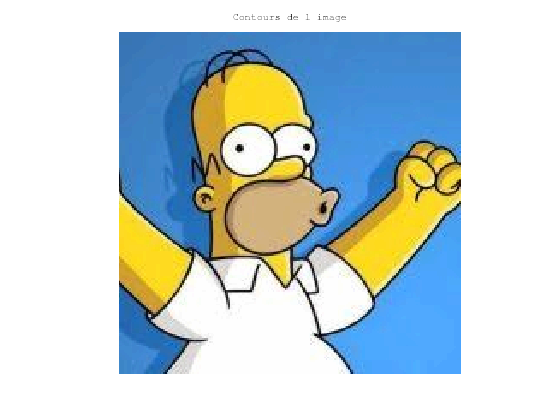

In [1]:
% Extraction de l'image dans un tableau
im = imread('homer.jpg');
figure; imshow(im,[]);title('Contours de l image');

Ny =  200
Nx_color =  200
Nz =  3
Ny =  200
Nx_grey =  200


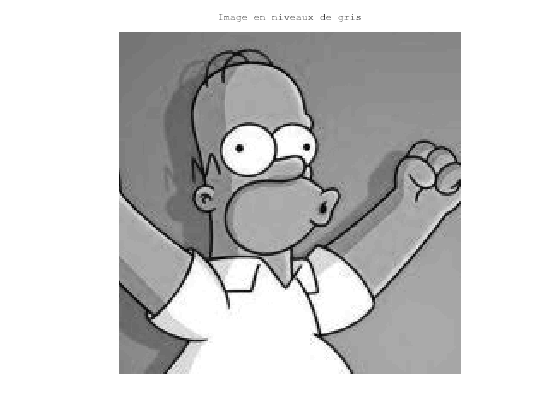

In [2]:
# Image en niveaux de gris
[Ny,Nx_color,Nz] = size(im)
im = double(sum(im,3));
[Ny,Nx_grey] = size(im)
figure; imshow(im,[]);title('Image en niveaux de gris');

En considérant l'image dans un repère orthogonal $(Oxy)$, où $(Ox)$ désigne l'axe horizontal et $(Oy)$ l'axe vertical, le gradient de l'image en tout point de coordonnées $(x,y)$ est défini par :
$$
\nabla I(x,y) = \left( \dfrac{\partial I(x,y)}{\partial x}, \dfrac{\partial I(x,y)}{\partial y} \right) 
$$

Soit $u$ le vecteur de $\mathbb{R}^2$ représentant l'image. Son gradient en tout pixel $(i,j)$ s'exprime donc sous la forme :
$$
\nabla u_{i,j} = \left( \dfrac{u_{i+1,j}-u_{i,j}}{\Delta x}, \dfrac{u_{i,j+1}-u_{i,j}}{\Delta y} \right) = (u_{i+1,j}-u_{i,j}, u_{i,j+1}-u_{i,j})
$$

In [3]:
% Fonction de calcul du gradient d'une image
function [gx,gy]=grad_im(im)

%renvoie deux images de même taille que im representant le gradient
%Chacune est une composante du gradient au point correspondant dans l'image

%taille de l'image (attention la dimension en y est en premier)
[Ny,Nx] = size(im);

% Gradients en x et en y
gx = im(:,2:end) - im(:,1:end-1);
% on complète par une colonne de zéros
gx = [gx zeros(Ny,1)];

gy = im(2:end,:) - im(1:end-1,:);
% on complète par une ligne de zéros
gy = [gy;zeros(1,Nx)];

endfunction

Pour la détection de contours on utilise souvent la norme du gradient, qui permet de quantifier l'amplitude du saut d'intensité dans l'image :
$$
\Vert \nabla I(x,y) \vert = \sqrt{\left( \dfrac{\partial I(x,y)}{\partial x}^2\right) +  \left(\dfrac{\partial I(x,y)}{\partial y}^2 \right) }
$$

La norme du vecteur image $u$ s'exprime donc en chaque pixel sous la forme :
$$
\Vert \nabla u_{i,j} \Vert= \sqrt{ (u_{i+1,j}-u_{i,j})^2 + (u_{i,j+1}-u_{i,j})^2}
$$

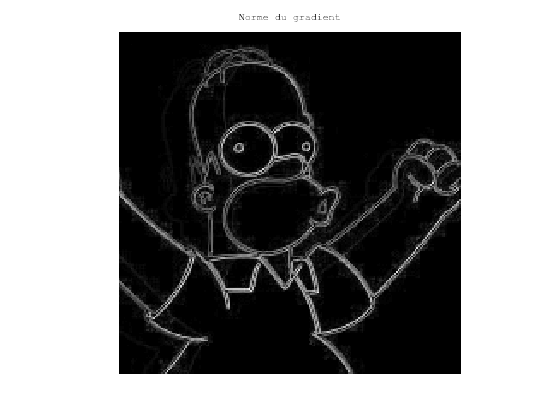

In [4]:
% Calcul de la norme du gradient
[gx,gy] = grad_im(im);
n = gx.^2 + gy.^2;
n = n.^0.5;
figure; imshow(n,[]);title('Norme du gradient');

## 2 -  Détection de droites

Une fois les bords de l'image détectés, on peut extraire les lignes droites. Pour cela, on peut utiliser la méthode d'extraction de lignes de Hough.

### Transformation de Hough

Considérons l'équation d'une droite dans un plan, avec deux paramètres $(a,b)$ :

$$
ax + by + 1 = 0
$$

Toute droite traversant une image peut être mise sous cette forme. Chacune de ces droites peut être représentée par un point dans le plan $(a,b)$.

La méthode de Hough repose sur l'utilisation d'un **accumulateur** dans le plan $(a,b)$. L'accumulateur est une matrice qui correspond à un domaine rectangulaire du plan $(a,b)$. Pour chaque pixel $M(x,y)$ de la norme de l'image, la droite d'équation $ax+by+1=0$ est tracée sur l'accumulateur : plus précisément, chaque pixel blanc rencontré (c'est à dire chaque pixel représentant un contour) est incrémenté d'une unité dans la matrice de l'accumulateur. Lorsque tous les points de l'image sont traités, les éléments de l'accumulateur les plus peuplés correspondent à des droites détectées.

Cependant, le paramétrage des droites par les coefficients $(a,b)$ n'est pas adapté à cette méthode, car les valeurs possibles de $a$ et $b$ ne sont pas bornées. Pour cette raison, Hough a utilisé une **paramétrisation des droites en coordonnées polaires** :

$$
x\cos(\theta) + y\cos(\theta) = \rho
$$

où $\theta \in [0, \pi]$ et $\rho \in [0, \sqrt{Nx^2 + Ny^2 }]$ (avec $Nx$ et $Ny$ le nombre de pixels dans la largeur et la hauteur de l'image).  
Cette équation représente une sinusoïde. Il faut bien sûr **échantillonner** cette **sinusoïde** de manière à remplir l'accumulateur de manière assez dense.

Lorsque tous les points de l'image ont été traités, on sélectionne les éléments de l'accumulateur remplis au dessus d'un certain **seuil**, qui sont alors interprétés comme les paramètres de droites correspondant à des lignes droites sur l'image. Le nombre d'éléments de l'accumulateur doit être choisi en fonction de la précision souhaitée. Par exemple, si l'on veut une précision de l'ordre du degré sur l'angle, il faut $N_{\theta}=180$ degrés. Cette précision a bien sûr un coût : plus le nombre de points est élevé, plus la sinusoïde doit être échantillonnée finement. 

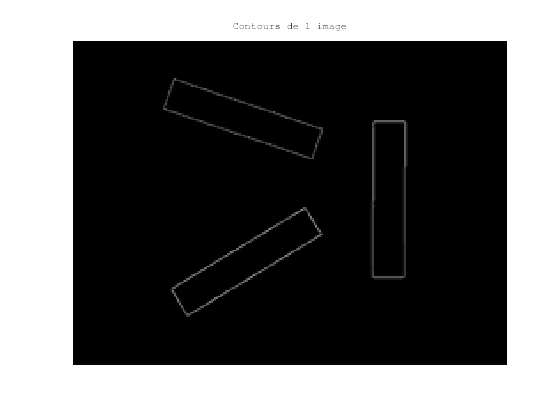

In [5]:
format long
% Extraction de l'image dans un tableau
%im = imread('homer.jpg');
im = imread('kapla_contours.png');
figure; imshow(flipud(im),[]);title('Contours de l image');

In [6]:
# Image en niveaux de gris
[Ny,Nx_color,Nz] = size(im);
im = double(sum(im,3));
[Ny,Nx_grey] = size(im);

In [7]:
[Ny, Nx] = size(im)
rho = 1.;
theta = 1.;
Ntheta = 180 / theta;
Nrho = int64(floor(sqrt(Nx * Nx + Ny * Ny)) / rho);
dtheta = pi / Ntheta;
drho = floor(sqrt(Nx * Nx + Ny * Ny)) / Nrho;
class(drho);
accum = zeros(Ntheta,Nrho);

Ny =  183
Nx =  245


In [8]:
for j = (1:Ny)
    for i = (1:Nx)
        if im(j,i)~=0
            for i_theta = (1:Ntheta)
                theta = (i_theta-1) * dtheta;
                rho = (i-1) * cos(theta) + (Ny - (j-1)) * sin(theta);
                i_rho = floor(rho);
                if (i_rho>0) && (i_rho<Nrho)
                    accum(i_theta,i_rho) = accum(i_theta,i_rho) + 1;
                end
            end
        end
    end
end

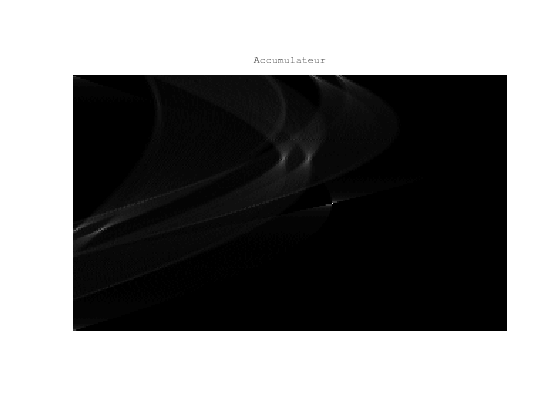

In [9]:
figure; imshow(accum,[]);title('Accumulateur');

seuil =  80


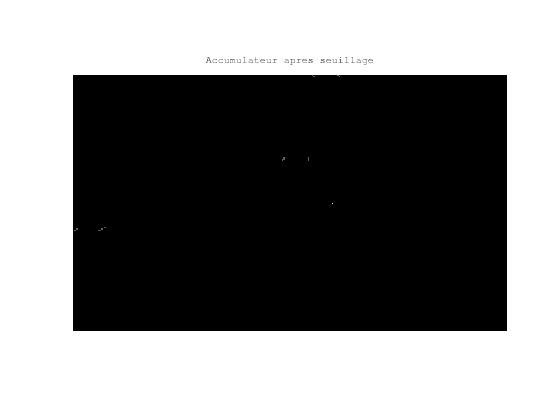

In [10]:
seuil = 80
accum_seuil = accum;
for i_theta = (1:Ntheta)
    for i_rho = (1:Nrho)
        if accum(i_theta,i_rho) < seuil
            accum_seuil(i_theta,i_rho) = 0;
        end
    end
end
            
figure; imshow(accum_seuil,[]);title('Accumulateur apres seuillage');

In [11]:
lignes = [];
for i_theta = (1:Ntheta)
    for i_rho = (1:Nrho)
        if accum_seuil(i_theta,i_rho)~=0
            xl = (i_rho)*drho;
            yl = (i_theta-1)*dtheta;
            lignes = [lignes [double(xl),double(yl)]];
        end
    end
end
[lx,ly] = size(lignes)

lx =  1
ly =  38


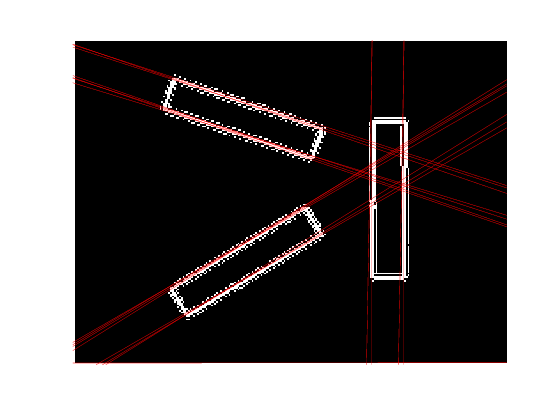

In [12]:
figure, imshow(flipud(im)), hold on
for i = (1:2:ly)
    a = cos(lignes(i+1));
    b = sin(lignes(i+1));
    x0 = a*lignes(i);
    y0 = b*lignes(i);
    x1 = floor(x0 + 1000*(-b));
    if x1 < 0
        x1 = x1 + 1;
    end
    y1 = floor(y0 + 1000*(a));
    if y1 < 0
        y1 = y1 + 1;
    end
    x2 = floor(x0 - 1000*(-b));
    if x2 < 0 
        x2 = x2 + 1;
    end
    y2 = floor(y0 - 1000*(a));
    if y2 < 0 
        y2 = y2 + 1;
    end
    plot([x1,x2],[y1,y2],color="r")
end